In [201]:
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib.pyplot as plt
import scipy
import scanpy as sc

In [202]:
import sys
sys.path.insert(0, '/home/ggorin/projects/monod/src/')
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis


In [203]:
# dataset_meta = ['allen_'+x for x in ['B05','B08','C01','F08','H12','B01','A01']]
# dataset_meta = ['allen_'+x for x in ['B08']]
# dataset_names = [x for x in dataset_meta ]  
# raw_data_locations = [x for x in dataset_meta]
# transcriptome_filepath = '../polyA_ref/gg_200524_mouse_genome_polyA_cum_1'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

# loom_filepaths = ['/home/ggorin/count_data/loom_allen_kb/'+x+'_raw.loom' for x in raw_data_locations] 
# n_datasets = len(loom_filepaths)


In [204]:
dataset_meta = 'pbmc_1k_v3'

In [205]:
bcs_filtered_loc = f'/home/ggorin/count_data/{dataset_meta}/counts_filtered/spliced.barcodes.txt'


In [206]:
bcs_raw_loc_S = f'/home/ggorin/count_data/{dataset_meta}/counts_unfiltered/spliced.barcodes.txt'
bcs_raw_loc_U = f'/home/ggorin/count_data/{dataset_meta}/counts_unfiltered/unspliced.barcodes.txt'

In [207]:
bcs_filtered = pd.read_csv(bcs_filtered_loc,header=None)
bcs_raw_S = pd.read_csv(bcs_raw_loc_S,header=None)
bcs_raw_U = pd.read_csv(bcs_raw_loc_U,header=None)

There's a shape mismatch. We need to merge the matrices into a common shape. We use the `kb` logic where the spliced barcodes are used as "ground truth".

nah let's try to use basic logic first

In [208]:
len(bcs_raw_S)

208549

In [209]:
len(bcs_raw_U)

179981

In [210]:
bcs_raw_U.isin(np.asarray(bcs_raw_S[0])).sum()

0    111231
dtype: int64

In [211]:
bcs_raw_S.isin(np.asarray(bcs_raw_U[0])).sum()

0    111231
dtype: int64

In [212]:
unique_bcs = list(np.unique(np.concatenate([bcs_raw_S,bcs_raw_U])))

In [213]:
len(unique_bcs)

277299

In [242]:
bcs = unique_bcs

In [247]:
# list(bcs_filtered)

In [219]:
assert unique_bcs == sorted(unique_bcs)
assert list(bcs_raw_S[0]) == sorted(bcs_raw_S[0])
assert list(bcs_raw_U[0]) == sorted(bcs_raw_U[0])


In [220]:
U_mtx_loc =  f'/home/ggorin/count_data/{dataset_meta}/counts_unfiltered/unspliced.mtx'
S_mtx_loc =  f'/home/ggorin/count_data/{dataset_meta}/counts_unfiltered/spliced.mtx'

In [227]:
S_raw = scipy.io.mmread(S_mtx_loc).T.astype(int)
U_raw = scipy.io.mmread(U_mtx_loc).T.astype(int)

In [228]:
U_ = scipy.sparse.coo_matrix((U_raw.shape[0],len(unique_bcs)),dtype=int)
S_ = scipy.sparse.coo_matrix((S_raw.shape[0],len(unique_bcs)),dtype=int)
assert U_.shape == S_.shape

In [229]:
qU = np.searchsorted(unique_bcs,bcs_raw_U[0]) 
qS = np.searchsorted(unique_bcs,bcs_raw_S[0])

In [230]:
U_.data = U_raw.data
U_.row = U_raw.row
U_.col = qU[U_raw.col]

S_.data = S_raw.data
S_.row = S_raw.row
S_.col = qS[S_raw.col]

In [235]:
U_raw = U_.tocsr()
S_raw = S_.tocsr()

In [236]:
thr_lb = 1e3

In [237]:
S_tot = np.squeeze(np.asarray(S_raw.sum(0)))
U_tot = np.squeeze(np.asarray(U_raw.sum(0)))

In [238]:
S_tot.shape

(277299,)

In [239]:
def knee_plot(umi_sum, ax1=None, thr=None, viz=False):
    n_cells = len(umi_sum)
    umi_rank = np.argsort(umi_sum)
    usf = np.flip(umi_sum[umi_rank])
    if viz:
        ax1.plot(np.arange(n_cells), usf, "k")
        ax1.set_xlabel("Cell rank")
        ax1.set_ylabel("UMI count+1")
        ax1.set_yscale("log")
    if thr is not None:
        cf = umi_sum > thr
        rank_ = np.argmin(np.abs(usf - thr))
        if viz:
            ax1.plot([0, n_cells + 1], thr * np.ones(2), "r--")
            ys = ax1.get_ylim()
            ax1.plot(rank_ * np.ones(2), ys, "r--")
        return cf


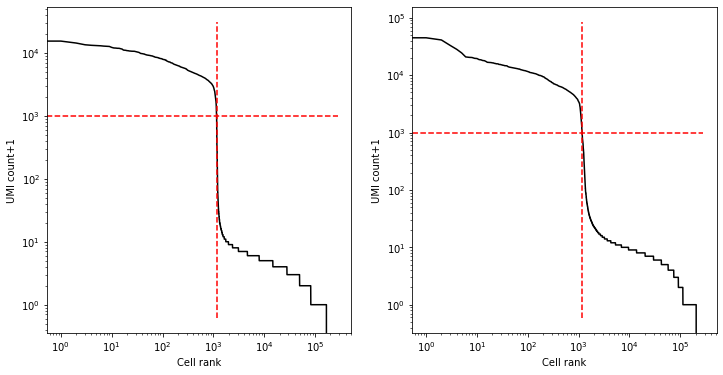

In [240]:
fig1,ax1 = plt.subplots(1,2,figsize=(12,6))
knee_plot(U_tot,ax1[0],viz=True,thr=thr_lb)
knee_plot(S_tot,ax1[1],viz=True,thr=thr_lb)
ax1[0].set_xscale('log')
ax1[1].set_xscale('log')

In [248]:
cf = np.isin(bcs,bcs_filtered)

In [249]:
len(cf)

277299

In [78]:
# cf = np.asarray(bcs_raw.isin(np.asarray(bcs_filtered).squeeze()),dtype=bool).squeeze()

In [250]:
cf.sum()

1200

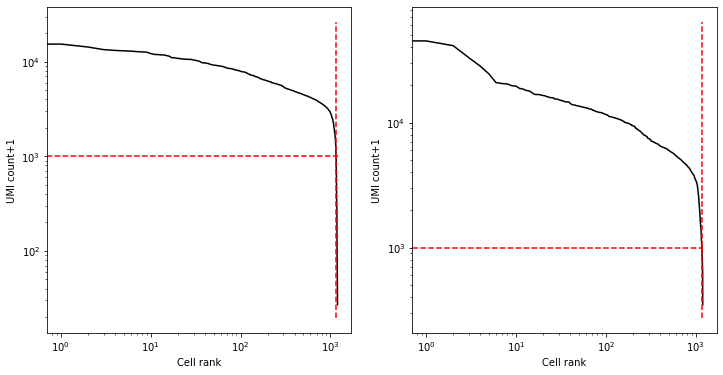

In [251]:
fig1,ax1 = plt.subplots(1,2,figsize=(12,6))
knee_plot(U_tot[cf],ax1[0],viz=True,thr=thr_lb)
knee_plot(S_tot[cf],ax1[1],viz=True,thr=thr_lb)
ax1[0].set_xscale('log')
ax1[1].set_xscale('log')

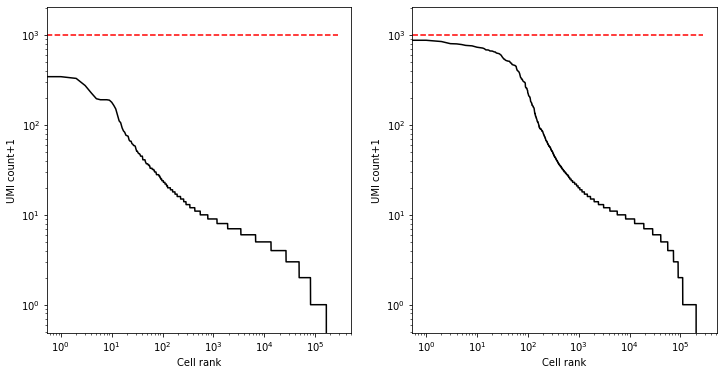

In [252]:
fig1,ax1 = plt.subplots(1,2,figsize=(12,6))
knee_plot(U_tot[~cf],ax1[0],viz=True,thr=thr_lb)
knee_plot(S_tot[~cf],ax1[1],viz=True,thr=thr_lb)
ax1[0].set_xscale('log')
ax1[1].set_xscale('log')

In [253]:
Smean.shape

(36601,)

In [254]:
Smean = np.asarray(S_raw.mean(1)).squeeze()
Umean = np.asarray(U_raw.mean(1)).squeeze()

In [255]:
Svar = np.asarray((S_raw.power(2)).mean(1)).squeeze()-Smean**2
Uvar = np.asarray((U_raw.power(2)).mean(1)).squeeze()-Umean**2

In [256]:
S_raw.shape

(36601, 277299)

In [257]:
xl[0]

0.0

In [258]:
xl = [min(Smean),max(Smean)]

In [268]:
def plot_meanvar(X,cf_,ax):
    mean = np.asarray(X[:,cf_].mean(1)).squeeze()
    var = np.asarray((X[:,cf_].power(2)).mean(1)).squeeze()-mean**2
    ax.scatter(mean,var,3,'k',alpha=0.4)
    mean = mean[mean>0]
    xl = [min(mean),max(mean)]
    ax.plot(xl,xl,'r--')
    ax.set_xscale("log")
    ax.set_yscale("log")

In [275]:
# #https://stackoverflow.com/a/19235925
# def sparse_corrcoef(A, B=None):

#     if B is not None:
#         A = sparse.vstack((A, B), format='csr')

#     A = A.astype(np.float64)
#     n = A.shape[1]

#     # Compute the covariance matrix
#     rowsum = A.sum(1)
#     centering = rowsum.dot(rowsum.T.conjugate()) / n
#     C = (A.dot(A.T.conjugate()) - centering) / (n - 1)

#     # The correlation coefficients are given by
#     # C_{i,j} / sqrt(C_{i} * C_{j})
#     d = np.diag(C)
#     coeffs = C / np.sqrt(np.outer(d, d))

#     return coeffs


In [276]:
# U_raw.shape

(36601, 277299)

In [ ]:
sparse_corrcoef()

In [318]:
def plot_corr(X,Y,cf_,ax):
    corrs = np.zeros(X.shape[0])
#     for k in range(len(corrs)):
# #         cov = np.asarray((X[k,cf_].multiply(Y[k,cf_])).mean(1)).squeeze()
# #         print(cov==0)
# #         raise ValueError
#         if cov==0:
#             continue
            
#         m1 = np.asarray(X[k,cf_].mean(1)).squeeze()
#         if m1==0:
#             continue
            
#         m2 = np.asarray(Y[k,cf_].mean(1)).squeeze()
#         if m2==0:
#             continue
            
#         std1 = np.sqrt(np.asarray((X[k,cf_].power(2)).mean(1)).squeeze() - m1**2)
#         if m2==0:
#             continue
            
#         std2 = np.sqrt(np.asarray((Y[k,cf_].power(2)).mean(1)).squeeze() - m2**2)
#         if m2==0:
#             continue
            
#         corrs[k] = cov/(std1*std2)
    corrs = np.asarray([np.corrcoef(x[0].toarray(),x[1].toarray())[0][1] for x in zip(X[:,cf_],Y[:,cf_])])
    #somehow this is actually faster
    mean = np.asarray(X[:,cf_].mean(1)).squeeze()
    ax.scatter(mean,corrs,3,'k',alpha=0.4)
    ax.set_xscale("log")
    return corrs

In [332]:
def plot_mean_bg(X,cf_,ax):
#     corrs = np.asarray([np.corrcoef(x[0].toarray(),x[1].toarray())[0][1] for x in zip(X[cf_].T,Y[cf_].T)])
#     mean1 = np.squeeze((np.mean(X[:].toarray(),0)))
#     mean2 = np.squeeze((np.mean(X[~cf_,:].toarray(),0)))
    
    mean1 = np.asarray(X[:,cf_].mean(1)).squeeze()
    mean2 = np.asarray(X[:,~cf_].mean(1)).squeeze()
    
    lm1 = np.log10(mean1)
    lm2 = np.log10(mean2)
    gf = np.isfinite(lm1) & np.isfinite(lm2)
    
    lm1 = lm1[gf]
    lm2 = lm2[gf]
    
    ax.scatter(mean1,mean2,3,'k',alpha=0.4)
    xl = np.array([min(mean1),max(mean1)])
    ax.plot(xl,xl,'r--')        
    ax.plot(xl,xl*2.4e-4,'b--')        
    ax.set_xscale("log")
    ax.set_yscale("log")
    return np.corrcoef(lm1,lm2)[0][1]

In [298]:
U_raw.shape

(36601, 277299)

In [295]:
S_raw.shape

(36601, 277299)

In [305]:
S_raw[600,cf].multiply(U_raw[600,cf])

<1x1200 sparse matrix of type '<class 'numpy.int64'>'
	with 4 stored elements in Compressed Sparse Row format>

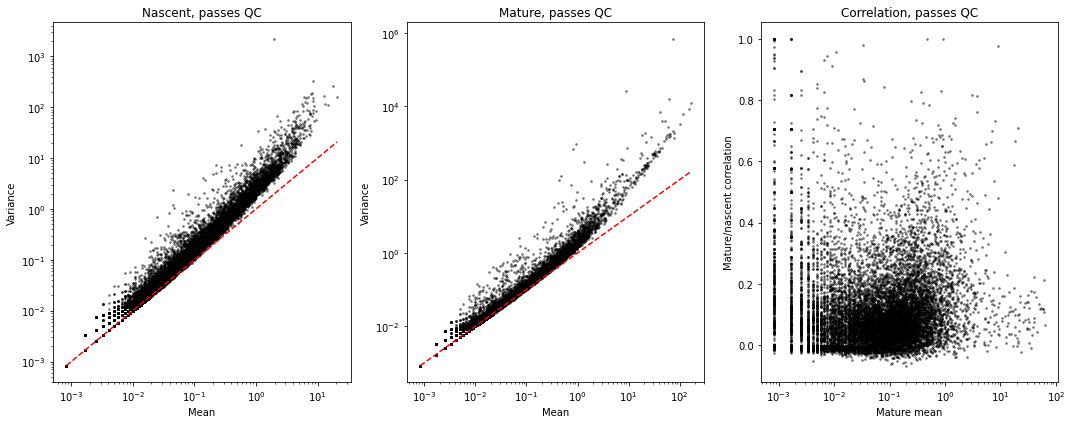

In [320]:
fig1,ax1 = plt.subplots(1,3,figsize=(15,6))

plot_meanvar(U_raw,cf,ax1[0])
ax1[0].set_title("Nascent, passes QC")
ax1[0].set_xlabel('Mean')
ax1[0].set_ylabel('Variance')

plot_meanvar(S_raw,cf,ax1[1])
ax1[1].set_title("Mature, passes QC")
ax1[1].set_xlabel('Mean')
ax1[1].set_ylabel('Variance')

corrs_qc = plot_corr(S_raw,U_raw,cf,ax1[2])
ax1[2].set_title("Correlation, passes QC")
ax1[2].set_xlabel('Mature mean')
ax1[2].set_ylabel('Mature/nascent correlation')

fig1.tight_layout()

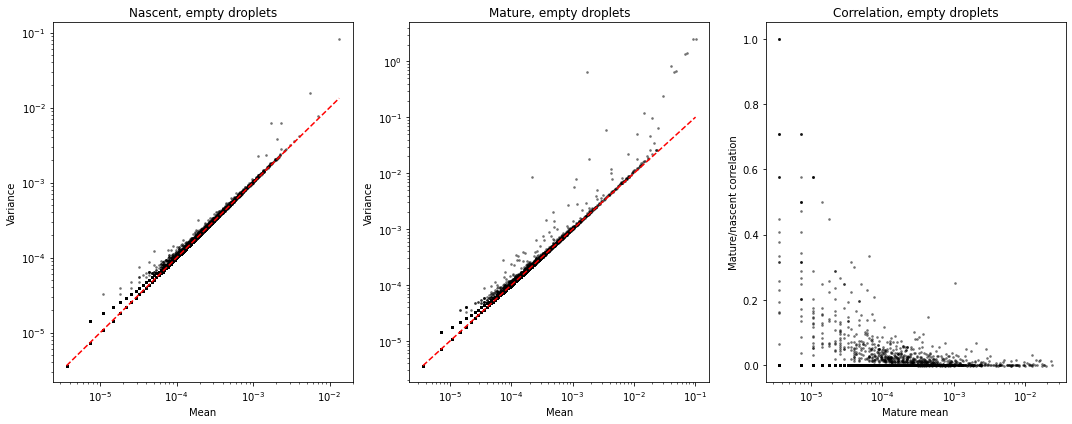

In [321]:
fig1,ax1 = plt.subplots(1,3,figsize=(15,6))
plot_meanvar(U_raw,~cf,ax1[0])
ax1[0].set_title("Nascent, empty droplets")
ax1[0].set_xlabel('Mean')
ax1[0].set_ylabel('Variance')

plot_meanvar(S_raw,~cf,ax1[1])
ax1[1].set_title("Mature, empty droplets")
ax1[1].set_xlabel('Mean')
ax1[1].set_ylabel('Variance')

corrs_empty = plot_corr(S_raw,U_raw,~cf,ax1[2])
ax1[2].set_title("Correlation, empty droplets")
ax1[2].set_xlabel('Mature mean')
ax1[2].set_ylabel('Mature/nascent correlation')


fig1.tight_layout()

In [325]:
len(corrs_qc)

36601

In [326]:
len(corrs_empty)

36601

Text(0, 0.5, 'Density')

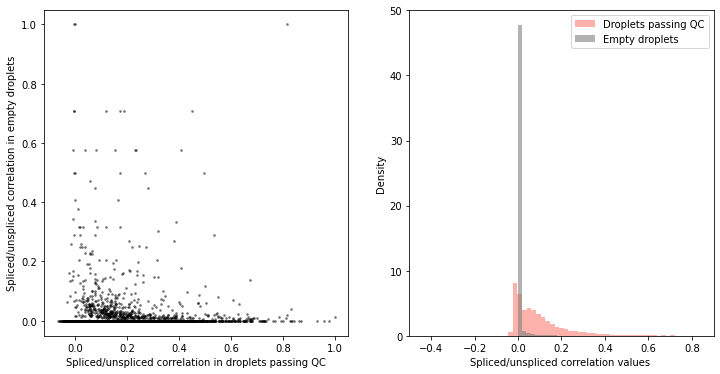

In [327]:
fig1,ax1 = plt.subplots(1,2,figsize=(12,6))
ax1[0].scatter(corrs_qc,corrs_empty,3,'k',alpha=0.4)
ax1[0].set_xlabel('Spliced/unspliced correlation in droplets passing QC')
ax1[0].set_ylabel('Spliced/unspliced correlation in empty droplets')

ax1[1].hist(corrs_qc,50,color = 'salmon',alpha=0.6,label='Droplets passing QC',density=True)
ax1[1].hist(corrs_empty,50,color = 'gray',alpha=0.6,label='Empty droplets',density=True)
ax1[1].legend()
ax1[1].set_xlim([-0.5,0.9])
ax1[1].set_xlabel('Spliced/unspliced correlation values ')
ax1[1].set_ylabel('Density')

/tmp/ipykernel_2898035/274176650.py:9: RuntimeWarning: divide by zero encountered in log10
  lm1 = np.log10(mean1)
/tmp/ipykernel_2898035/274176650.py:10: RuntimeWarning: divide by zero encountered in log10
  lm2 = np.log10(mean2)


Text(0, 0.5, 'Mean in empty droplets')

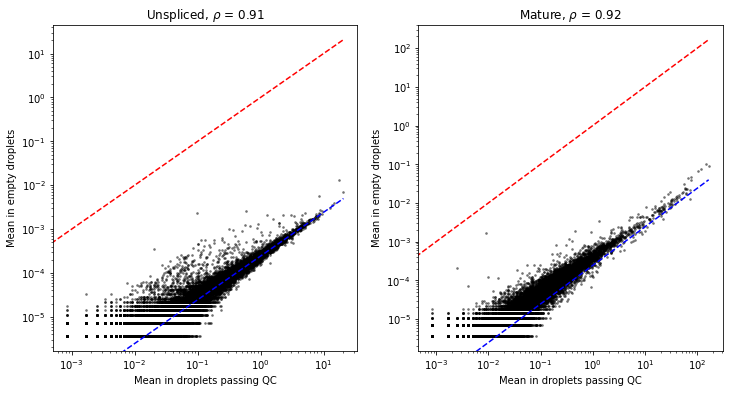

In [333]:
fig1,ax1 = plt.subplots(1,2,figsize=(12,6))
rho_U = plot_mean_bg(U_raw,cf,ax1[0])
ax1[0].set_title(r"Unspliced, $\rho$ = {:.2f}".format(rho_U))
ax1[0].set_xlabel('Mean in droplets passing QC')
ax1[0].set_ylabel('Mean in empty droplets')

rho_S = plot_mean_bg(S_raw,cf,ax1[1])
ax1[1].set_title(r"Mature, $\rho$ = {:.2f}".format(rho_S))
ax1[1].set_xlabel('Mean in droplets passing QC')
ax1[1].set_ylabel('Mean in empty droplets')

In [334]:
# S_raw.shape

(36601, 277299)

In [347]:
gf = np.asarray(S_raw.sum(1)>0,dtype=bool).squeeze()

In [348]:
gf.shape

(36601,)

In [363]:
S_raw[gf][:,cf]

<17584x1200 sparse matrix of type '<class 'numpy.int64'>'
	with 1975014 stored elements in Compressed Sparse Row format>

In [365]:
genecorr_qc_S = np.corrcoef(S_raw[gf][:,cf].toarray())
genecorr_qc_S = genecorr_qc_S[np.triu_indices(len(genecorr_qc_S),1)]

In [367]:
np.corrcoef(S_raw[gf][:,cf].toarray()).shape

(17584, 17584)

In [369]:
gf.sum()

17584

In [370]:
genecorr_empty_S = np.corrcoef(S_raw[gf][:,~cf].toarray())
genecorr_empty_S = genecorr_empty_S[np.triu_indices(len(genecorr_empty_S),1)]

Text(0, 0.5, 'Density')

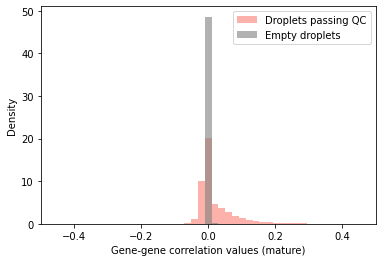

In [385]:
bins = np.linspace(-0.5,0.5,50)
plt.hist(genecorr_qc_S,bins,color = 'salmon',alpha=0.6,label='Droplets passing QC',density=True)
plt.hist(genecorr_empty_S,bins,color = 'gray',alpha=0.6,label='Empty droplets',density=True)
plt.legend()
plt.xlim([-0.5,0.5])
plt.xlabel('Gene-gene correlation values (mature)')
plt.ylabel('Density')

In [372]:
gf = np.asarray(U_raw.sum(1)>0,dtype=bool).squeeze()

In [373]:
genecorr_qc_U = np.corrcoef(U_raw[gf][:,cf].toarray())
genecorr_qc_U = genecorr_qc_U[np.triu_indices(len(genecorr_qc_U),1)]

In [374]:
genecorr_empty_U = np.corrcoef(U_raw[gf][:,~cf].toarray())
genecorr_empty_U = genecorr_empty_U[np.triu_indices(len(genecorr_empty_U),1)]

Text(0, 0.5, 'Density')

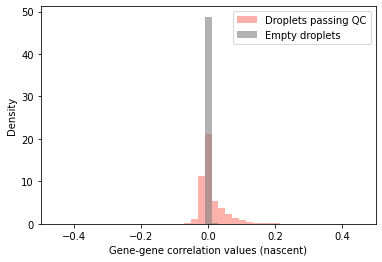

In [386]:
bins = np.linspace(-0.5,0.5,50)
plt.hist(genecorr_qc_U,bins,color = 'salmon',alpha=0.6,label='Droplets passing QC',density=True)
plt.hist(genecorr_empty_U,bins,color = 'gray',alpha=0.6,label='Empty droplets',density=True)
plt.legend()
plt.xlim([-0.5,0.5])
plt.xlabel('Gene-gene correlation values (nascent)')
plt.ylabel('Density')

In [381]:
np.asarray(S_raw[:,~cf].sum(0)).squeeze().mean()

2.669176635916827

In [382]:
np.asarray(S_raw[:,~cf].sum(0)).squeeze().var()

115.90649221447612

In [383]:
np.asarray(S_raw[:,cf].sum(0)).squeeze().mean()

6296.7525

In [384]:
np.asarray(S_raw[:,cf].sum(0)).squeeze().var()

16441835.00624375

In [388]:
# gf = (raw_data.layers[spliced_layer]).toarray().sum(0)>1
# genecov_qc = np.cov(raw_data.layers[spliced_layer][cf][:,gf].T.toarray())
# genecov_qc = genecov_qc[np.triu_indices((genecov_qc).shape[1],1)]
# # genecov_empty = np.cov(raw_data.layers[spliced_layer][~cf][:,gf].T.toarray())
# # genecov_empty = genecorr_empty[np.triu_indices((genecorr_empty).shape[1],1)]


In [389]:
# genecov_empty = np.cov(raw_data.layers[spliced_layer][~cf][:,gf].T.toarray())


In [390]:
# genecov_empty = genecov_empty[np.triu_indices((genecov_empty).shape[1],1)]
# 

In [391]:
# genecov_qc.shape

In [392]:
# genecov_empty.shape

In [393]:
# plt.hist(genecov_qc,50,color = 'salmon',alpha=0.6,label='Droplets passing QC',density=True)
# plt.hist(genecov_empty,50,color = 'gray',alpha=0.6,label='Empty droplets',density=True)
# plt.legend()
# # plt.xlim([-0.5,0.5])
# plt.xlabel('Gene-gene covariance values (spliced)')
# plt.ylabel('Density')

In [394]:
# plt.scatter(genecov_qc,genecov_empty)

In [395]:
# genecov_qc

In [396]:
# print('hello')

In [397]:
# np.cov(raw_data.layers[spliced_layer][~cf][:,gf].toarray()).shape

In [398]:
# np.cov(raw_data.layers[spliced_layer][cf][:,gf].toarray()).shape

In [399]:
# S_tot_qc = raw_data.layers[spliced_layer][cf].toarray().sum(1)
# S_tot_empty = raw_data.layers[spliced_layer][~cf].toarray().sum(1)

In [400]:
# S_tot_empty.shape

In [401]:
# bins =np.linspace(-0.5,50000,100)
# plt.hist(S_tot_qc,bins,color = 'salmon',alpha=0.6,label='Droplets passing QC',density=True)
# plt.hist(S_tot_empty,bins,color = 'gray',alpha=0.6,label='Empty droplets',density=True)
# plt.xlabel('Cell size')
# plt.ylabel('Density')

In [402]:
# S_tot_empty.var()

In [403]:
# S_tot_empty.mean()

In [404]:
# S_tot_qc.var()/S_tot_qc.mean()

In [405]:
# S_fano_qc.shape

In [406]:
# S_qc = raw_data.layers[spliced_layer][cf][:,gf].T.toarray()
# S_mean_qc = S_qc.mean(1)
# S_fano_qc = S_qc.var(1)/S_mean_qc
# U_qc = raw_data.layers[unspliced_layer][cf][:,gf].T.toarray()
# U_mean_qc = U_qc.mean(1)
# U_fano_qc = U_qc.var(1)/U_mean_qc

In [407]:
# fig1,ax1 = plt.subplots(1,2,figsize=(12,6))

# ax1[0].scatter(U_mean_qc,U_fano_qc-1,3,'k',alpha=.3)
# ax1[0].set_xscale('log')
# ax1[0].set_yscale('log')
# ax1[0].set_xlabel('Mean unspliced in droplets passing QC')
# ax1[0].set_ylabel('Fano unspliced - 1 in droplets passing QC')

# ax1[1].scatter(S_mean_qc,S_fano_qc-1,3,'k',alpha=.3)
# ax1[1].set_xscale('log')
# ax1[1].set_yscale('log')
# ax1[1].set_xlabel('Mean spliced in droplets passing QC')
# ax1[1].set_ylabel('Fano spliced - 1 in droplets passing QC')
# xl = [S_mean_qc.min(),S_mean_qc.max()]
# yl = [np.quantile(S_fano_qc[S_fano_qc>1]-1,0.05)]*2
# ax1[1].plot(xl,yl,'r--')

In [408]:
# np.quantile(S_fano_qc[S_fano_qc>1]-1,0.01)

In [409]:
# S_empty = raw_data.layers[spliced_layer][~cf][:,gf].T.toarray()
# S_mean_empty = S_empty.mean(1)
# S_fano_empty = S_empty.var(1)/S_mean_empty
# U_empty = raw_data.layers[unspliced_layer][~cf][:,gf].T.toarray()
# U_mean_empty = U_empty.mean(1)
# U_fano_empty = U_empty.var(1)/U_mean_empty


In [410]:
# U_fano_empty.shape

In [411]:

# fig1,ax1 = plt.subplots(1,2,figsize=(12,6))


# ax1[0].scatter(U_mean_empty,U_fano_empty-1,3,'k',alpha=.3)
# ax1[0].set_xscale('log')
# ax1[0].set_yscale('log')
# ax1[0].set_xlabel('Mean unspliced in empty droplets')
# ax1[0].set_ylabel('Fano unspliced - 1 in empty droplets')

# ax1[1].scatter(S_mean_empty,S_fano_empty-1,3,'k',alpha=.3)
# ax1[1].set_xscale('log')
# ax1[1].set_yscale('log')
# ax1[1].set_xlabel('Mean spliced in empty droplets')
# ax1[1].set_ylabel('Fano spliced - 1 in empty droplets')
# xl = [S_mean_empty.min(),S_mean_empty.max()]
# yl = [np.quantile(S_fano_empty[S_fano_empty>1]-1,0.05)]*2
# ax1[1].plot(xl,yl,'r--')

# # ax1[0].scatter(S_mean_empty,S_fano_empty+1,3,'k',alpha=.6)
# # ax1[0].set_xscale('log')
# # ax1[0].set_yscale('log')
# # ax1[0].set_xlabel('Mean spliced in empty droplets')
# # ax1[0].set_ylabel('Fano spliced - 1 in empty droplets')

# # ax1[1].scatter(U_mean_empty,U_fano_empty+1,3,'k',alpha=.6)
# # ax1[1].set_xscale('log')
# # ax1[1].set_yscale('log')
# # ax1[1].set_xlabel('Mean unspliced in empty droplets')
# # ax1[1].set_ylabel('Fano unspliced - 1 in empty droplets')

In [412]:
# S_fano_empty[S_fano_empty>1].shape

In [413]:
# raw_data.layers[spliced_layer]

In [415]:
# a e s t h e t i c s


In [418]:
X =  S_raw

m1 = np.asarray(X[:,cf].mean(1)).squeeze()
v1 = np.asarray((X[:,cf].power(2)).mean(1)).squeeze()-m1**2
m2 = np.asarray(X[:,~cf].mean(1)).squeeze()
v2 = np.asarray((X[:,~cf].power(2)).mean(1)).squeeze()-m2**2


In [ ]:

fs = 14
fig1,ax1 = plt.subplots(1,4,figsize=(15,4))

############
ax1[0].scatter(m1,v1,3,'salmon',alpha=0.2,label='Droplets passing QC')
ax1[0].scatter(m2,v2,3,'gray',alpha=0.8,label='Empty droplets')

xl = [1e-5,1e2]
ax1[0].plot(xl,xl,c='dodgerblue',label='Poisson',alpha=1,linestyle=(0,(5,10)))        
ax1[0].set_xscale("log")
ax1[0].set_yscale("log")
ax1[0].set_xlabel('Mature mean',fontsize=fs)
ax1[0].set_ylabel('Mature variance',fontsize=fs)
ax1[0].legend(markerscale=6)

############
ax1[1].hist(corrs_qc,50,color = 'salmon',alpha=0.6,label='Droplets passing QC',density=True)
ax1[1].hist(corrs_empty,50,color = 'gray',alpha=0.6,label='Empty droplets',density=True)
# ax1[1].legend()
ax1[1].set_xlim([-0.6,0.6])
ax1[1].set_xlabel(r'Nascent/mature $\rho$',fontsize=fs)
ax1[1].set_ylabel('Density',fontsize=fs)

#############

ax1[2].hist(genecorr_qc,50,color = 'salmon',alpha=0.6,label='Droplets passing QC',density=True)
ax1[2].hist(genecorr_empty,50,color = 'gray',alpha=0.6,label='Empty droplets',density=True)
# ax1[2].legend(loc='upper left')
ax1[2].set_xlim([-0.4,0.4])
ax1[2].set_xlabel(r'Gene-gene $\rho$ (mature)',fontsize=fs)
ax1[2].set_ylabel('Density',fontsize=fs)
    
#############
gf = (m1>0) & (m2>0)
lm1 = np.log10(m1[gf])
lm2 = np.log10(m2[gf])


ax1[3].scatter(m1,m2,3,'k',alpha=0.07)
xl = np.array([min(m1),max(m1)])
ax1[3].plot(xl,xl,'k--')        
ax1[3].set_xscale("log")
ax1[3].set_yscale("log")
ax1[3].text(0.4,0.45,r'$\rho$ = {:.2f}'.format(np.corrcoef(lm1,lm2)[0][1]),transform=ax1[3].transAxes,fontsize=fs+2)
ax1[3].set_xlabel('Mature mean in\ndroplets passing QC',fontsize=fs)
ax1[3].set_ylabel('Mature mean in empty droplets',fontsize=fs)


fig1.tight_layout()
plt.subplots_adjust(right=1.05)


In [531]:
gf.sum()

11650

In [529]:
(~np.isnan(genecorr_empty)).sum()

95323528

In [530]:
(~np.isnan(genecorr_qc)).sum()

172208961

In [526]:
(~np.isnan(corrs_qc)).sum()

14365

In [527]:
(~np.isnan(corrs_empty)).sum()

8815

In [525]:
(v2>0).sum()

11800

In [523]:
cf.sum()

1200

In [440]:
np.polyfit(lm1,lm2,1)

array([ 0.80912217, -3.1804193 ])

In [402]:
 np.squeeze(X[cf_,:].power(2).mean(0))

matrix([[0.00583333, 0.01333333, 0.00166667, ..., 0.00083333, 0.00916667,
         0.        ]], dtype=float32)

In [517]:
x_ = np.arange(7)
poiss1 = scipy.stats.poisson(0.5)
poiss2 = scipy.stats.poisson(0.3)
y1 = poiss1.pmf(x_)
y2 = poiss2.pmf(x_)

Text(0.95, 0.7, '$P(n,m) = P(n;c\\mu_N)\\times P(m;c\\mu_M)$')

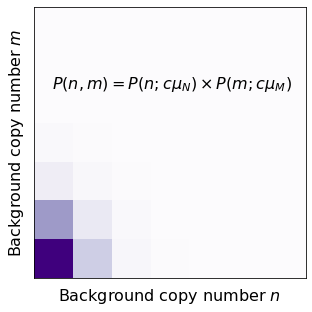

In [518]:

Y = np.outer(y1,y2)
plt.figure(figsize=(5,5))
ax = plt.gca()
plt.imshow((Y),cmap='Purples')
plt.gca().invert_yaxis()
plt.xticks([])
plt.yticks([])
plt.xlabel(r'Background copy number $n$',fontsize=fs+4)
plt.ylabel(r'Background copy number $m$',fontsize=fs+4)
ax.text(0.95,0.7,r'$P(n,m) = P(n;c\mu_N)\times P(m;c\mu_M)$',transform=ax.transAxes,fontsize=fs+4,horizontalalignment='right')

# plt.savefig('nbprod.png',dpi=450,transparent=True)

     


In [485]:
y1

array([1., 0., 0., 0., 0., 0., 0.])

In [486]:
y2

array([8.60707976e-01, 1.29106196e-01, 9.68296473e-03, 4.84148237e-04,
       1.81555589e-05, 5.44666766e-07, 1.36166692e-08])

In [480]:
y1

array([1., 0., 0., 0., 0., 0., 0.])